# Facial Features
 
Team: Cynthia Hom

I referenced the [FastAI documentation](https://docs.fast.ai/) and adapted code from it for this assignment, [Lab 7](https://www.cs.hmc.edu/~rhodes/courses/cs152/sp21/labs/lab7.html).

The idea of this notebook is to create a filter of a playing card on people's foreheads. The filter will tilt when the person's head is tilted, and be centered on their forehead, with the bottom of the card located at the top of their eyebrows. Eventually, I'd like to include this filter in a video-calling app that allows myself and my friends to virtually play a game called "push-up poker", where we put cards on our foreheads and bet pushups on who has the highest card.

## Installations and Downloading Data

We install fastai and download the [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/data) dataset from Kaggle. The dataset consists of two zip files, `'training.zip'` and `'test.zip'`, both of which are csv files when unzipped.

`'training.csv'` contains 7049 96x96 pixel grayscale images with 15 labeled facial keypoints: left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, and mouth_center_bottom_lip.

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 204kB 24.9MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
!pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "XXX" # username from the json file, hidden for sharing purposes
os.environ['KAGGLE_KEY'] = "XXX" # key from the json file, hidden for sharing purposes

In [ ]:
!kaggle competitions download -c facial-keypoints-detection

  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 57.4MB/s]
 98% 59.0M/60.1M [00:01<00:00, 29.0MB/s]
100% 60.1M/60.1M [00:01<00:00, 39.0MB/s]
 56% 9.00M/16.0M [00:00<00:00, 85.8MB/s]
100% 16.0M/16.0M [00:00<00:00, 102MB/s] 
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 197MB/s]


We import the necessary libraries and then open the Kaggle data using `ZipFile`, as suggested by this [fastai post](https://forums.fast.ai/t/how-to-use-images-in-a-zip-fie/51823/3).

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from fastai.vision.all import *
import cv2
import imutils
import PIL

In [ ]:
from zipfile import ZipFile
with ZipFile('test.zip', 'r') as zip_ref_test:
  zip_ref_test.extractall()
with ZipFile('training.zip', 'r') as zip_ref_train:
  zip_ref_train.extractall()

## Dataset

We use `read_csv` to create a pandas dataframe from `"training.csv"`.

In [ ]:
df = pd.read_csv("training.csv")

Note that `test.csv` just contains the test data for the kaggle competition, so it is not of use to us.

In [ ]:
test_df = pd.read_csv("test.csv")
test_df.head()

ImageId                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Image
0        1  182 183 182 182 180 180 176 169 156 137 124 103 79 62 54 56 58 48 49 45 39 37 42 43 52 61 78 93 104 107 114 115 117 122 120 122 118 114 115 118 117 123 122 122 112 113 118 125 124 122 109 101 96 102 108 107 100 89 76 67 58 48 44 36 32 21 12 5 15 21 24 33 32 41 52 63 71 90 106 121 152 173 180 183 182 182 183 182 182 181 182 182 183 182 182 182 182 181 181 181 182 179 177 162 136 106 84 64 49 44 40 50 50 42 36 33 32 43 51 67 77 94 106 121 124 128 127 126 128 128 129 126 126 122 128 123 128 123 129 127 133 123 128 129 135 127 122 111 115 118 120 121 118 114 107 107 99 89 74 70 59 47 29 18 16 ...
1        2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 47 37 33 32 33 35 50 55 54 50 51 61 78 92 100 101 79 55 47 52 50 47 39 38 52 46 25 25 39 52 63 59 67 79 68 48 44 44 43 44 45 53 56 55 50 48 54 58 51 52 67 72 86 76 64 75 97 97 83 85 81 67 53 45 39 33 33 53 73 60 44 47 72 98 121 120 117 127 120 115 117 68 85 84 72 63 52 57 69 69 49 34 40 46 57 63 58 45 39 30 31 35 47 52 47 52 53 54 70 84 93 104 94 67 50 48 49 48 39 35 48 53 44 33 35 47 66 73 73 73 69 58 48 42 41 51 52 54 58 51 49 53 60 59 49 46 61 72 87 82 66 71 93 108 95 83 85 81 64 58 54 42 33 48 66 57 45 53 72 88 110 125 125 134 132 111 106 63...
2        3  177 176 174 170 169 169 168 166 166 166 161 140 69 5 1 2 1 18 61 96 110 122 129 129 127 125 125 119 112 110 111 107 102 102 99 96 98 95 91 90 91 94 92 88 86 86 86 85 86 87 84 84 87 88 85 85 86 84 87 97 96 96 99 101 105 107 111 109 94 68 31 3 2 48 141 164 137 123 124 120 106 100 103 107 114 115 112 113 112 110 114 113 114 114 111 111 176 174 171 169 168 166 166 164 162 163 158 107 24 0 2 0 7 50 98 119 128 134 131 132 131 129 125 120 116 110 113 111 104 105 106 101 97 92 86 88 90 92 92 93 91 86 88 87 89 89 85 88 88 87 89 88 87 88 89 93 97 101 101 100 103 109 110 109 106 93 63 20 0 7 83 155 1...
3        4  176 174 174 175 174 174 176 176 175 171 165 157 143 134 134 137 138 137 135 135 134 137 135 128 128 129 122 110 107 112 115 123 134 147 151 151 152 155 157 160 164 166 168 168 167 168 169 172 177 178 180 184 188 192 194 191 189 184 177 171 165 154 146 130 118 111 104 99 99 101 105 112 117 119 119 117 116 116 114 121 135 151 161 166 173 174 174 175 174 173 173 173 173 171 171 172 175 175 174 176 176 174 175 176 174 170 159 149 141 136 136 136 138 143 140 136 136 133 123 125 133 126 114 118 126 133 144 157 166 169 166 167 169 174 178 183 191 194 193 189 190 192 196 199 203 206 206 207 211 21...
4        5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 38 36 34 31 31 32 32 34 34 34 35 33 32 30 31 33 33 31 33 35 35 35 33 34 34 31 34 33 32 35 39 36 39 42 42 42 40 39 38 38 34 33 34 35 38 37 36 37 41 44 48 51 51 52 54 56 56 60 61 61 63 62 67 76 75 79 81 81 62 52 209 255 251 254 254 254 254 254 254 254 254 254 49 49 47 111 153 136 88 51 43 36 38 37 39 38 36 34 32 32 34 32 34 35 34 32 30 32 32 31 31 31 32 33 32 33 37 35 38 39 37 34 33 34 37 39 40 38 42 44 43 42 41 40 40 38 35 37 38 39 41 41 40 38 42 42 44 48 51 52 54 56 57 61 62 63 66 64 64 73 76 78 83 82 89 51 73 216 255 253 254 254 254 254 254 25...

We convert the last column from a strings consisting of pixel values separated by spaces to a tensors of floating point values between 0 and 255. Note that all images are grayscale and have size 96x96 pixels.

In [ ]:
IMG_SHAPE = (96, 96)
def stringToArr(stringIn):
  return np.array([float(value) for value in stringIn.split(' ')]).reshape(IMG_SHAPE)

In [ ]:
df['Image'] = df['Image'].map(stringToArr)

Let's look at one image in the new dataframe.

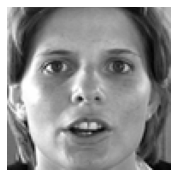

In [ ]:
show_image(df['Image'][31], cmap='gray')

Note that there are NaN values in the dataframe. Let's remove them.

In [ ]:
df.isnull().values.any()

True

In [ ]:
df = df.dropna()
len(df)

2140

Note that some faces are repeated! We'll need a way to make sure that the same person does not have images in both training and validation datasets.

/usr/local/lib/python3.7/dist-packages/fastai/torch_core.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: _,ax = plt.subplots(figsize=figsize)


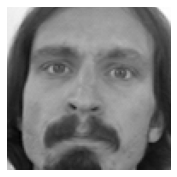

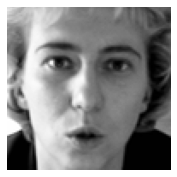

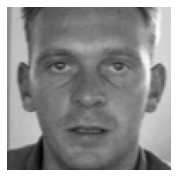

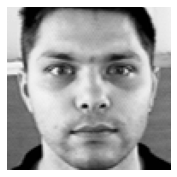

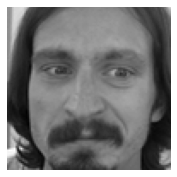

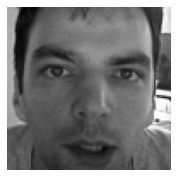

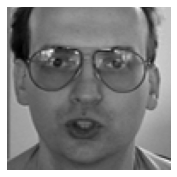

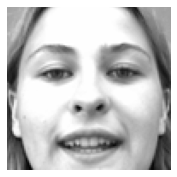

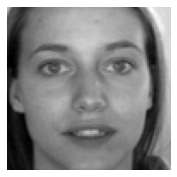

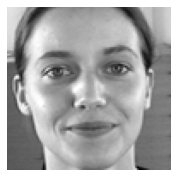

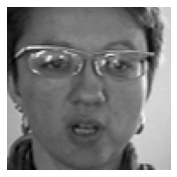

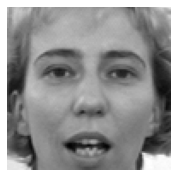

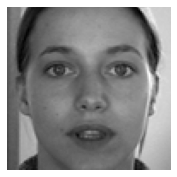

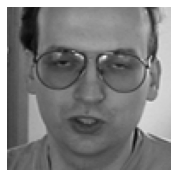

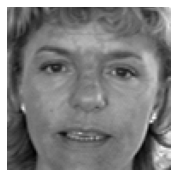

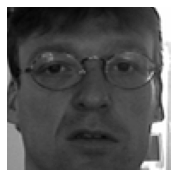

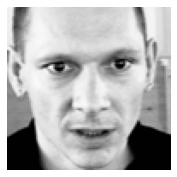

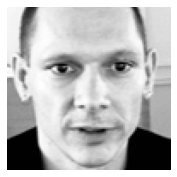

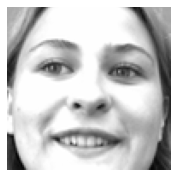

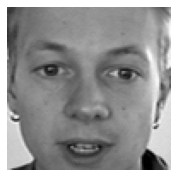

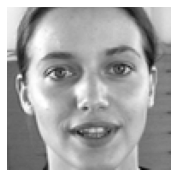

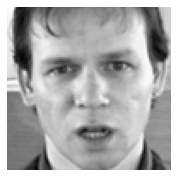

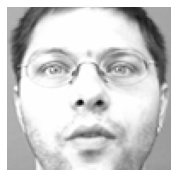

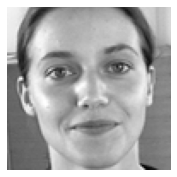

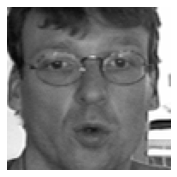

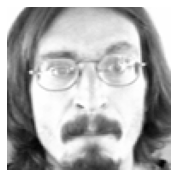

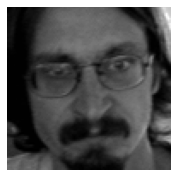

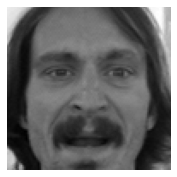

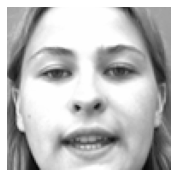

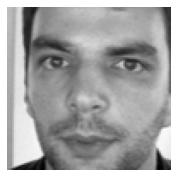

In [ ]:
for i in range(30): 
  show_image(df['Image'][i], cmap="gray")

To solve this, we picked out all the images of 5 different people (about 400 total) to use as the validation data set. Note that there are about 2140 images total without nan values, so 400 is about 20% of the total data without nan values. The following five people are the people in the validation dataset.

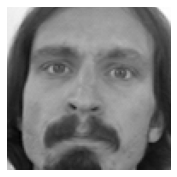

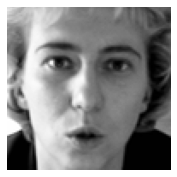

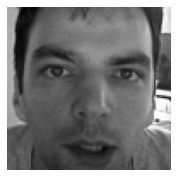

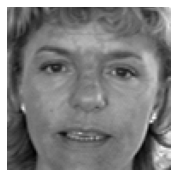

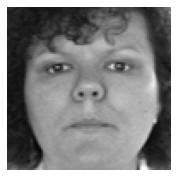

In [ ]:
for i in [0, 1, 5, 14, 502]:
  show_image(df['Image'][i], cmap="gray")


The result of this data processing is the csv file [`"isValid.csv"`](https://drive.google.com/file/d/1hlIJ47fqWAIVV1ylVDt2rAYF022_BxgU/view?usp=sharing), which contains a 1 for every row that has an image with one of the 5 people mentioned above, and a 0 elsewhere. 

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
isValidPath = Path('/content/drive/My Drive/Colab Notebooks/lab7valid')
isValidPath.ls()

(#1) [Path('/content/drive/My Drive/Colab Notebooks/lab7valid/isValid.csv')]

We read in the csv, specifying `header=None`, since there is no header in the csv. 

In [ ]:
isValidDf = pd.read_csv(isValidPath/"isValid.csv", header=None)
isValidDf.head()

0
0  1
1  1
2  0
3  0
4  1

We use this csv to create new column for the dataframe, `'is_valid'`, which contains a 1 for every row that should be in the validation dataset, and a 0 elsewhere.

In [ ]:
df["is_valid"] = isValidDf

Let's confirm that the images in the `is_valid` column are all one of the 5 people we picked out.

0 is in is_valid
1 is in is_valid
4 is in is_valid
5 is in is_valid
11 is in is_valid
14 is in is_valid
25 is in is_valid
26 is in is_valid
27 is in is_valid
29 is in is_valid
32 is in is_valid
34 is in is_valid
35 is in is_valid
39 is in is_valid
42 is in is_valid
45 is in is_valid
47 is in is_valid
48 is in is_valid


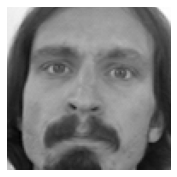

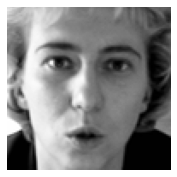

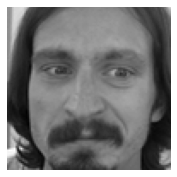

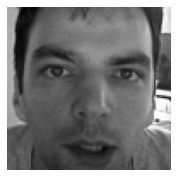

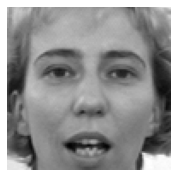

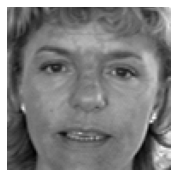

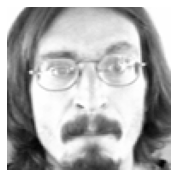

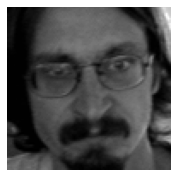

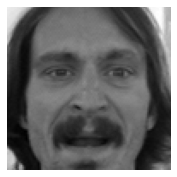

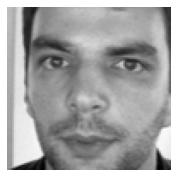

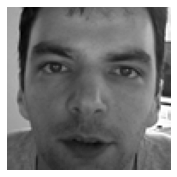

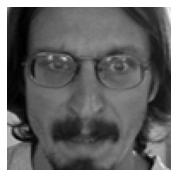

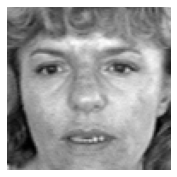

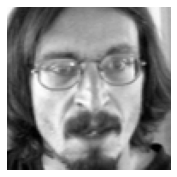

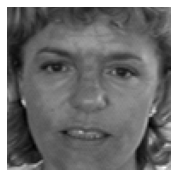

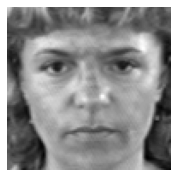

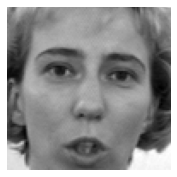

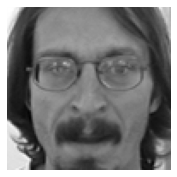

In [ ]:
for i in range(50):
  if df['is_valid'][i] == 1: 
    print(f"{i} is in is_valid")
    show_image(df['Image'][i], cmap='gray')

## Dataloaders

The last two columns are the `'Image'` and `'is_valid'` columns, and the rest are the facial keypoints.

In [ ]:
df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image', 'is_valid'],
      dtype='object')

We make a `DataBlock`. We use fastai's `ImageBlock` in order to treat the inputs as objects of type `PILImage`, and use `PointBlock` because our outputs are of type `TensorPoint`. We specify `ColSplitter()` for our Splitter, which defaults to using the column `is_valid`. We specify a `get_y` function that will return the keypoints for the outer eyebrows and nose. For data augmentation, we specify a larger rotation angle to account for cases where people tilt their heads while video calling.

I referenced this [fastai forum](https://forums.fast.ai/t/fastbook-chp-6-multiple-pointblocks/73316/4) to figure out how to use `PointBlock` and how to define `get_y`.




`get_y(r)` creates a list of x-y pairs to be passed into the `PointBlock`.

In [ ]:
def get_y(r):
    return [
    [r['left_eyebrow_outer_end_x'], r['left_eyebrow_outer_end_y']],
    [r['right_eyebrow_outer_end_x'], r['right_eyebrow_outer_end_y']],
    [r['nose_tip_x'], r['nose_tip_y']],
    ]

In [ ]:
get_y(df)

[[0       80.227128
  1       78.634213
  2       78.887368
  3       77.910261
  4       77.762945
            ...    
  2277    80.709708
  2278    81.314059
  2281    85.829396
  2282    77.354898
  2283    80.947787
  Name: left_eyebrow_outer_end_x, Length: 2140, dtype: float64,
  0       32.228138
  1       30.405923
  2       32.651621
  3       31.665725
  4       31.737247
            ...    
  2277    30.595738
  2278    30.754762
  2281    38.724104
  2282    19.562755
  2283    27.977535
  Name: left_eyebrow_outer_end_y, Length: 2140, dtype: float64],
 [0       16.356379
  1       16.865362
  2       16.791158
  3       20.458017
  4       15.925870
            ...    
  2277    17.275454
  2278     8.578912
  2281    11.230184
  2282     9.731633
  2283    14.798890
  Name: right_eyebrow_outer_end_x, Length: 2140, dtype: float64,
  0       29.647471
  1       27.058860
  2       32.087116
  3       29.909343
  4       30.672177
            ...    
  2277    29.534964
  2278

In [ ]:
db = DataBlock(blocks=(ImageBlock, PointBlock),
                    splitter=ColSplitter(),
                    get_x=ColReader('Image'),
                    get_y=get_y,
                    batch_tfms=aug_transforms(max_rotate=90.0))

In [ ]:
db.summary(df)

Setting-up type transforms pipelines
0             66.033564  ...       1.0
1             64.332936  ...       1.0
2             65.057053  ...       0.0
3             65.225739  ...       0.0
4             66.725301  ...       1.0
...                 ...  ...       ...
2277          67.180378  ...       NaN
2278          65.724490  ...       NaN
2281          68.430866  ...       NaN
2282          64.152180  ...       NaN
2283          66.683755  ...       NaN

[2140 rows x 32 columns]
Found 2140 items
2 datasets of sizes 1623,517
Setting up Pipeline: ColReader -- {'cols': 'Image', 'pref': '', 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: get_y -> TensorPoint.create

Building one sample
  Pipeline: ColReader -- {'cols': 'Image', 'pref': '', 'suff': '', 'label_delim': None} -> PILBase.create
    starting from
      left_eye_center_x                                                                                                                                  

We create a dataloaders object from the DataBlock created earlier.

In [ ]:
dls = db.dataloaders(df)

We show a batch from the dataloaders, and specify `cmap='gray'` in order to show the images in grayscale, as they should be shown. The red dots signify the three facial keypoints that we are training the model to predict: `'left_eyebrow_outer_end'`, `'right_eyebrow_outer_end'`, and `'nose_tip'`. 

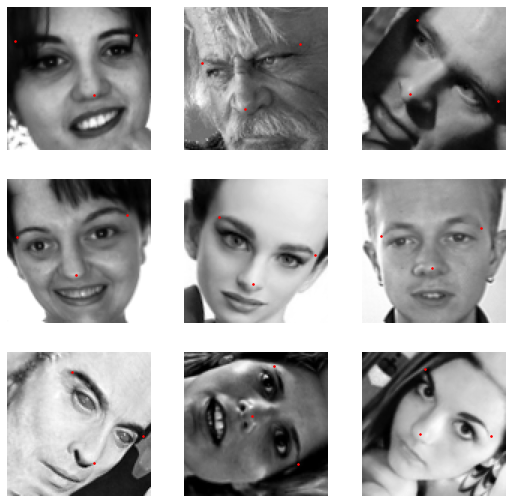

In [ ]:
dls.show_batch(cmap='gray')

Again, we confirm that the images in the training and validation datasets do not have the same people.

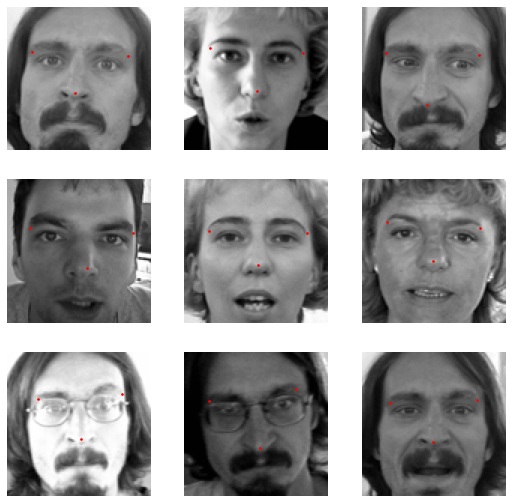

In [ ]:
dls.valid.show_batch(cmap="gray")

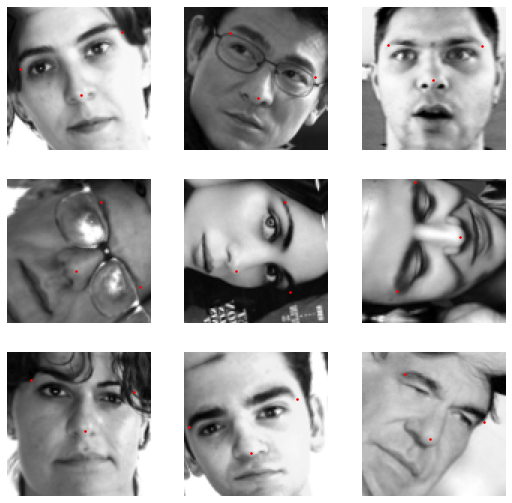

In [ ]:
dls.train.show_batch(cmap="gray")

## Training

We use a pretrained convolutional neural network, with the `resnet34` architecture. 


In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Let's take a look at `learn`.

In [ ]:
learn.children

<bound method Module.children of Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [ ]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 48 x 48   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

We use `lr_find()` to find a good learning rate for training. It seems that `5e-3` is a decent learning rate.

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.033113110810518265)

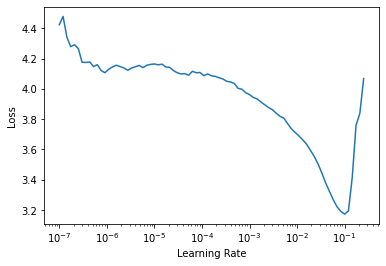

In [ ]:
learn.lr_find()

Because the model is pretrained, we use `fine_tune()` to fit the model. We use `SaveModelCallback` to access the best performing model from the epochs.

In [ ]:
learn.fine_tune(50, base_lr = 5e-3, cbs=SaveModelCallback()) 

Better model found at epoch 0 with valid_loss value: 2.4936137199401855.


Better model found at epoch 0 with valid_loss value: 0.8725523352622986.
Better model found at epoch 1 with valid_loss value: 0.4068019390106201.
Better model found at epoch 2 with valid_loss value: 0.30248627066612244.
Better model found at epoch 3 with valid_loss value: 0.25684911012649536.
Better model found at epoch 4 with valid_loss value: 0.19635139405727386.
Better model found at epoch 5 with valid_loss value: 0.16586515307426453.
Better model found at epoch 6 with valid_loss value: 0.15817895531654358.
Better model found at epoch 7 with valid_loss value: 0.1409517377614975.
Better model found at epoch 12 with valid_loss value: 0.11978607624769211.
Better model found at epoch 14 with valid_loss value: 0.09994179755449295.
Better model found at epoch 17 with valid_loss value: 0.07996418327093124.
Better model found at epoch 20 with valid_loss value: 0.07586292922496796.
Better model found at epoch 24 with valid_loss value: 0.057833172380924225.
Better model found at epoch 26 with

We use `show_results()` to show some of the predictions of our model.

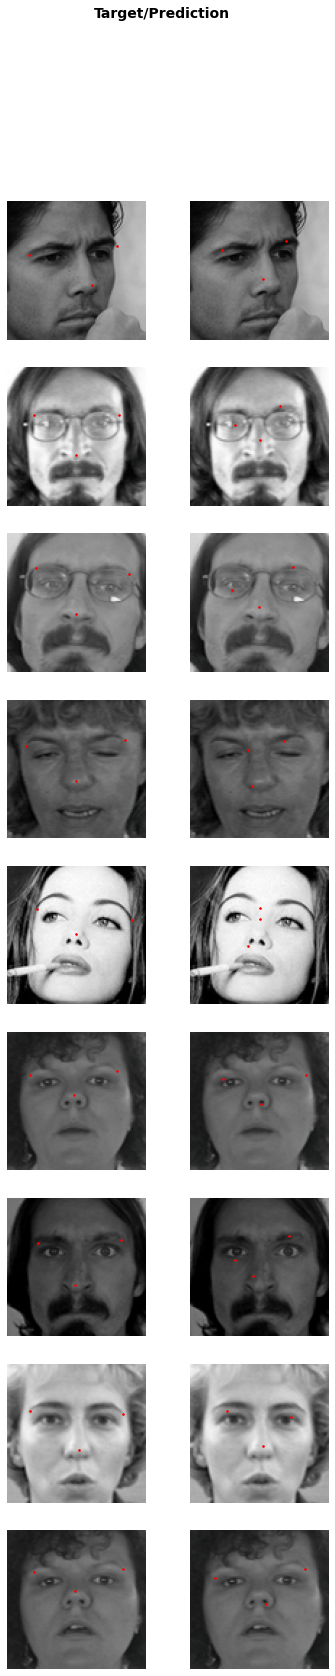

In [ ]:
learn.show_results() 

Export the model. The model will be saved in a file called `"export.pkl"`.

In [ ]:
learn.export()

## Prediction

We define a function that takes in an image array, uses a `cnn_learner` to make the predictions, and shows the result. I used the example in the [TensorPoint fastai documentation](https://docs.fast.ai/vision.core.html#TensorPoint) to figure out how to show `TensorPoint` objects on the image.

In [ ]:
def predict(image, learn):
  """image: Image on which to predict"""
  output = learn.predict(image)
  tensorPoints = output[0] 
  ctx = TensorImage(image).show(figsize=(5,5), cmap='gray')
  tensorPoints.show(ctx=ctx);
  return tensorPoints

Here is the result of predicting one of the images in the validation dataset.

TensorPoint([[75.2049, 25.3605],
        [19.1582, 40.9728],
        [49.7745, 49.6647]])

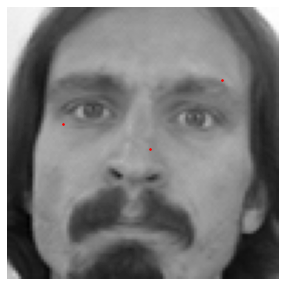

In [ ]:
predict(df['Image'][0], learn)

Let's upload some pictures of our own! The code to upload the files was taken from the [Day 1 In-Class Assignment](https://colab.research.google.com/drive/1InSMNkmYJfzuy0bQo0O-rm4xj8RyXXvM#scrollTo=PgaZvog84XxV) of this course.

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving barty.jpeg to barty.jpeg
Saving federer.jpeg to federer.jpeg
Saving gauff.jpeg to gauff.jpeg
Saving halep.jpeg to halep.jpeg
Saving halep#2.jpeg to halep#2.jpeg
Saving LiNa.png to LiNa.png
Saving nadal.jpeg to nadal.jpeg
Saving osaka.jpeg to osaka.jpeg
Saving osaka#2.jpeg to osaka#2.jpeg
Saving venus#2.jpg to venus#2.jpg
Saving venusWilliams.jpeg to venusWilliams.jpeg
User uploaded file "barty.jpeg" with length 199889 bytes
User uploaded file "federer.jpeg" with length 81683 bytes
User uploaded file "gauff.jpeg" with length 529075 bytes
User uploaded file "halep.jpeg" with length 5864 bytes
User uploaded file "halep#2.jpeg" with length 12062 bytes
User uploaded file "LiNa.png" with length 141018 bytes
User uploaded file "nadal.jpeg" with length 26677 bytes
User uploaded file "osaka.jpeg" with length 30081 bytes
User uploaded file "osaka#2.jpeg" with length 241597 bytes
User uploaded file "venus#2.jpg" with length 14552 bytes
User uploaded file "venusWilliams.jpeg" with length 10

We loop through the uploaded images and make predictions. We first show the predictions on the resized grayscale image, and then on the original image. The neural net does okay on images centered on the face, but doesn't do so well on images that are off center or that have lots of background. We'll fix that in the next section, when we apply the filter.

In [ ]:
def predictTestImage(img, learn):
  tensorPointsGrayscale = predict(np.array(img.convert('L').resize((96, 96))), learn) 
  ratios = tensor(img.shape)/tensor([96, 96])
  # Swap because in TensorPoints are (x, y), 
    # i.e. First element is column index, second is row index
  ratios = tensor(ratios[1], ratios[0]) 
  originalPos = ratios * tensorPointsGrayscale
  ctxImg = TensorImage(img).show()
  originalPos.show(ctx=ctxImg);

/usr/local/lib/python3.7/dist-packages/fastai/torch_core.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: _,ax = plt.subplots(figsize=figsize)


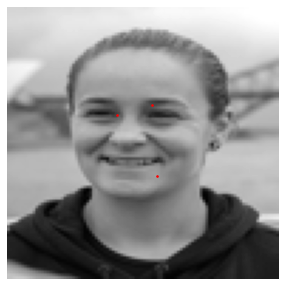

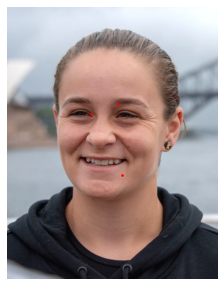

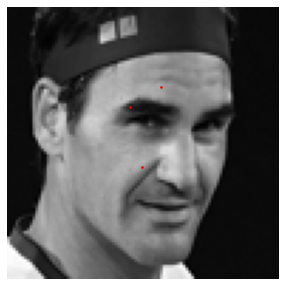

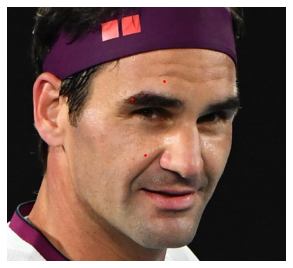

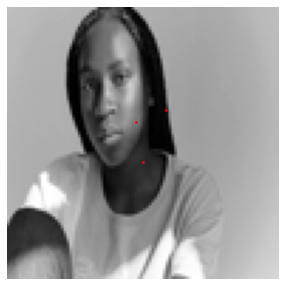

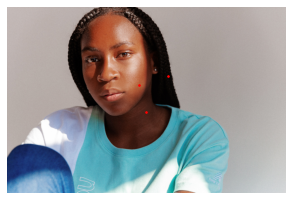

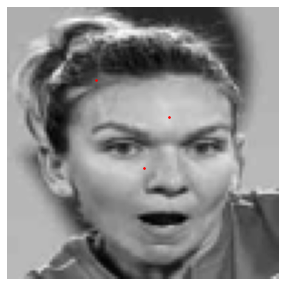

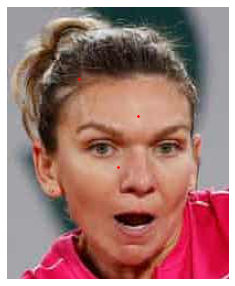

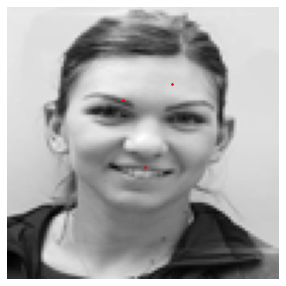

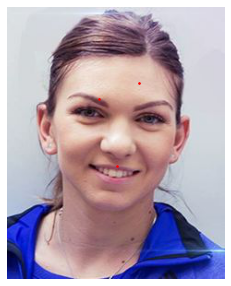

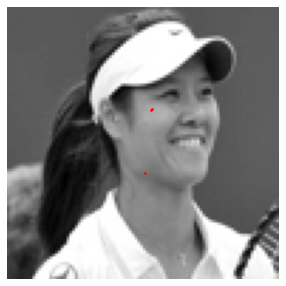

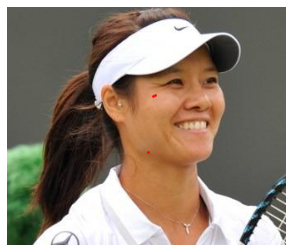

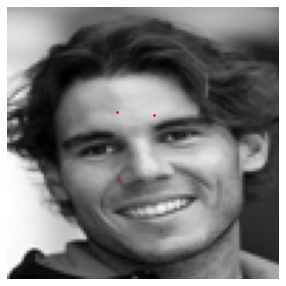

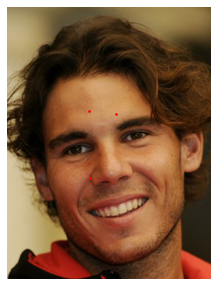

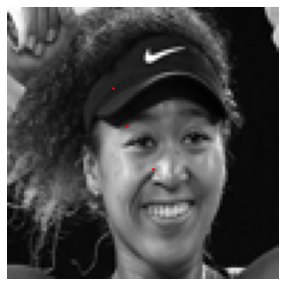

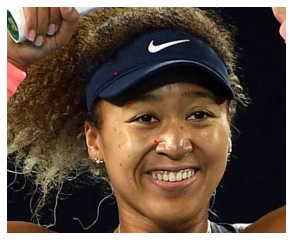

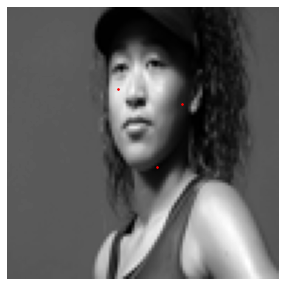

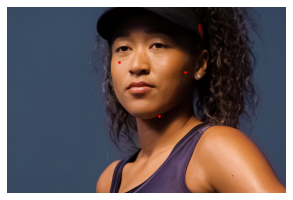

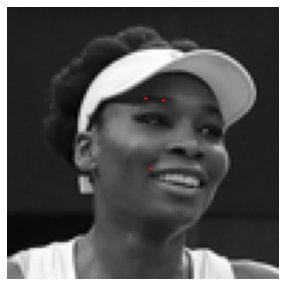

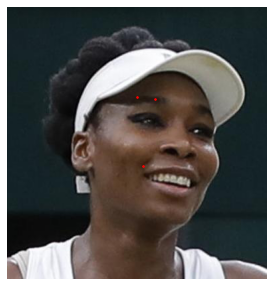

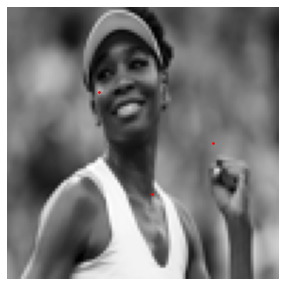

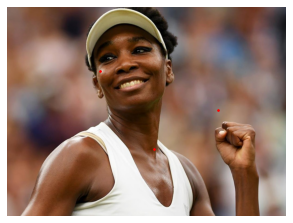

In [ ]:
for imgName in uploaded.keys():
  img = PILImage.create(imgName)
  predictTestImage(img, learn)

## Applying the Filter

We download a set of playing card images from the [American Contract Bridge League](http://acbl.mybigcommerce.com/52-playing-cards/).

In [ ]:
cardImgs = untar_data('http://web2.acbl.org/documentlibrary/marketing/Clip_Art/cards_png_zip.zip')
cardImgs.ls()

(#64) [Path('/root/.fastai/data/cards_png_zip/9S.png'),Path('/root/.fastai/data/cards_png_zip/honor_clubs.png'),Path('/root/.fastai/data/cards_png_zip/AD.png'),Path('/root/.fastai/data/cards_png_zip/4C.png'),Path('/root/.fastai/data/cards_png_zip/3D.png'),Path('/root/.fastai/data/cards_png_zip/QH.png'),Path('/root/.fastai/data/cards_png_zip/blue_back.png'),Path('/root/.fastai/data/cards_png_zip/5H.png'),Path('/root/.fastai/data/cards_png_zip/red_back.png'),Path('/root/.fastai/data/cards_png_zip/4H.png')...]

Let's show the ace of spades (the most powerful card in push-up-poker)!

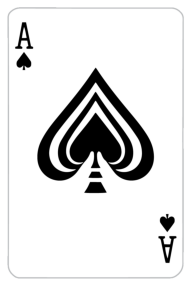

In [ ]:
path = cardImgs/"AS.png"
spadeAce = PILImage.create(path)
show_image(spadeAce)

We will use `imutils` to create a rotated version of the image that doesn't cut off its corners, following this [post](https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/).

In [ ]:
import imutils

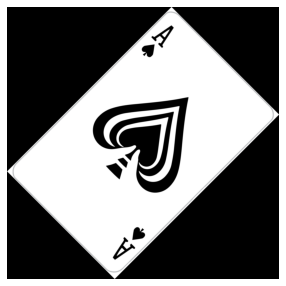

In [ ]:
rotatedSpadeAce2 = imutils.rotate_bound(np.array(spadeAce), angle=45)
show_image(rotatedSpadeAce2)

Since the neural net did not do so well on faces with lots of background in the previous section, we use OpenCV Haar cascades to extract the faces from the images before running keypoint detection. We use code from this [tutorial](https://learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/). Here is an example of it working on Rafael Nadal.

face: [ 30 105 236 236]


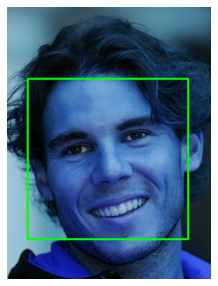

In [ ]:
cascPath = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
image = cv2.imread("nadal.jpeg")
face = faceCascade.detectMultiScale(image)[0]
x,y,w,h = face
print(f"face: {face}")
cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2) 
show_image(image)

We now create some functions to do the entire process, including applying the filter.
We first create our Haar cascade instance. 

In [ ]:
cascPath = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

`applyFilter` will take in an image name, and output the result of applying the filter to it. 

In [ ]:
def applyFilter(imgName, imgFilterPath, learn):
  # Create images
  img = np.array(PILImage.create(imgName))
  filterImg = PILImage.create(imgFilterPath)
  tensorPoints = getTensorPoints(img, imgName, learn)

  # The point between the eyebrows will be the bottom middle of the playing card
  btwnEyebrows = (tensorPoints[0] + tensorPoints[1])/2
  xBtwnEyebrows = int(btwnEyebrows[0])
  yBtwnEyebrows = int(btwnEyebrows[1])
  nose = tensorPoints[2]
  
  # Card height is about twice distance between btwnEyebrows and nose
  cardHeight = int(2*np.sqrt(sum(np.square(btwnEyebrows - nose))))
  
  # Overlay the filter on the original image
  newImg = getFilterFrame(img, filterImg, cardHeight, btwnEyebrows, nose)
  ctxImg = TensorImage(newImg).show()
  tensorPoints.show(ctx=ctxImg);

  return newImg

`getTensorPoints` is a helper function for `applyFilter` which will take in an image, pick out only the face, run the neural net on the face, and then return the tensor points.

In [ ]:
def getTensorPoints(img, imgName, learn):
  # Get only the face, and account for the case where no face is found.
  faces = faceCascade.detectMultiScale(img, minNeighbors=1, minSize=(int(img.shape[0]/10), int(img.shape[0]/10)))
  if len(faces) > 1:
    print("faces greater than 1 for " + imgName)
  if len(faces) != 0:
    x,y,w,h = faces[0]
    onlyFaceImg = img[y:y + h, x:x + w]
  else:
    x = 0; y = 0; h, w = img.shape[:2]
    onlyFaceImg = img
    print("no face found for " + imgName)

  # Show the rectangle when we show the image later
  cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

  # Get tensor points
  grayscaleImg = np.array(PILImage.create(onlyFaceImg).convert('L').resize((96, 96)))
  tensorPointsGrayscale = learn.predict(grayscaleImg)[0]

  # Adjust tensor points for original image size.
  ratios = tensor(onlyFaceImg.shape[:2])/tensor([96, 96])
  ratios = tensor(ratios[1], ratios[0]) 
  
  # Multiply by ratios and add x, y to adjust for cropping
  return ratios * tensorPointsGrayscale + tensor(x, y)

`getFilterFrame` is a helper function for `applyFilter` that will take in the original image, the image to use as the filter, and parameters related to the position of the filter on the original image. It will then return the new frame, with the filter applied.

In [ ]:
def getFilterFrame(img1, filterImage, filterHeight, btwnEyebrows, nose):
  yBtwnEyebrows = int(btwnEyebrows[1])
  xBtwnEyebrows = int(btwnEyebrows[0])
  difference = nose - btwnEyebrows
  angle = -np.arctan(difference[0]/difference[1]) * 180.0/np.pi

  # Calculations
  resizeRatio = filterHeight/filterImage.shape[0]
  filterWidth = int(filterImage.shape[1]*resizeRatio)
  resizedFilter = filterImage.resize((filterWidth, filterHeight))
  rotatedResizedFilter = imutils.rotate_bound(np.array(resizedFilter), angle=angle)

  # Use to black out parts of original image
  binaryCard = np.zeros(np.array(resizedFilter).shape) + 1
  rotatedBinary = imutils.rotate_bound(binaryCard, angle=angle)
  inverseBinary = (rotatedBinary < 1).astype(int)

  # Calculate position of card on image
  endX = int(xBtwnEyebrows + filterWidth/2 * np.cos(-angle*np.pi/180))
  endY = int(yBtwnEyebrows + filterWidth/2 * np.sin(-angle*np.pi/180)) # use trig
  startY = endY - inverseBinary.shape[0]
  startX = endX - inverseBinary.shape[1]

  # Calculate starting indicies of the card to show 
    # (Accounts for going over the edge of original image)
  startYC = 0; endYC = inverseBinary.shape[0]; startXC = 0; endXC = inverseBinary.shape[1]

  # Adjust for edge cases
  if (startY < 0): # top
    startYC = abs(startY)
    startY = 0
  if (startX < 0): # left
    startXC = abs(startX)
    startX = 0
  if (endY > img1.shape[0]): # bottom
    endYC = endY - img1.shape[0]
    endY = img1.shape[0]
    print("updating end y")
  if (endX > img1.shape[1]): # right
    endXC = endX - img1.shape[1]
    endX = img1.shape[1]

  # Create image to multiply by to black out filter area
  toMult = np.ones(np.array(img1).shape)
  toMult[startY:endY, startX:endX,:] = inverseBinary[startYC:endYC, startXC:endXC, :]

  # Create image to add to put in filter
  toAdd = np.zeros(np.array(img1).shape)
  toAdd[startY:endY, startX:endX,:] = rotatedResizedFilter[startYC:endYC, startXC:endXC, :]

  # Create final image
  finalImg = (np.array(img1) * toMult + toAdd).astype(int)

  return finalImg

Let's run the code on our test images! In addition to the filter, we also show the bounding box and the detected keypoints for our own knowledge. The neural net is still not perfect, but does significantly better than it did earlier, when we did not crop the images before running them through the neural net.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


no face found for LiNa.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


no face found for venusWilliams.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


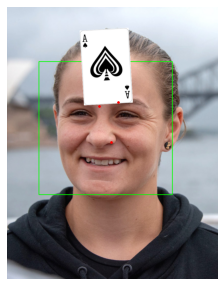

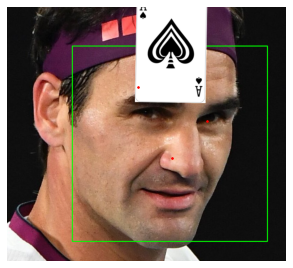

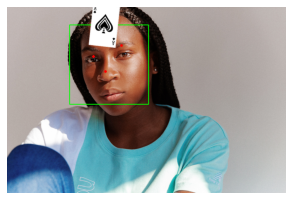

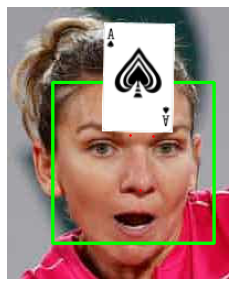

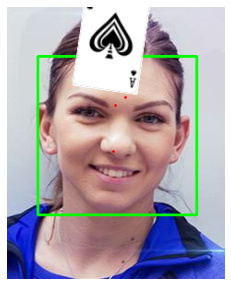

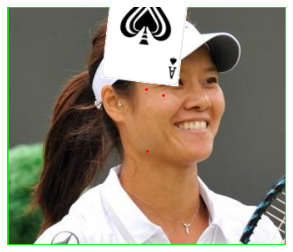

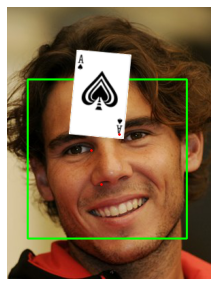

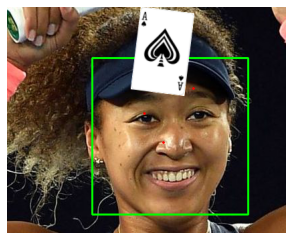

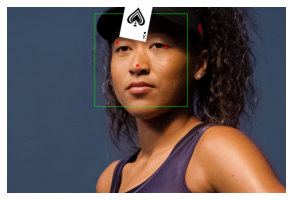

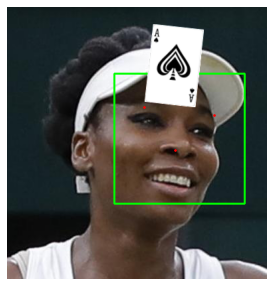

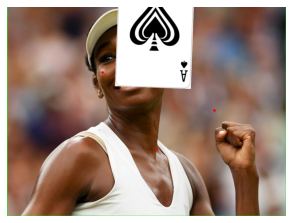

In [ ]:
for imgName in uploaded.keys():
  applyFilter(imgName, cardImgs/"AS.png", learn)

Note that in addition to this, I also created a javascript program that takes in a live incoming video feed and applies the filter. It is not yet "deployed", but instead runs locally on my laptop. The goal is to eventually include it in a video calling app, but I haven't finished the video calling part yet. Here is [a short screen recording demo](https://drive.google.com/file/d/1qEn1j5_tIJaLMasbz_N0Z4ByFoUHetuE/view?usp=sharing) of the program. The demo video is only shared with Harvey Mudd students and faculty. If you are not a Harvey Mudd student or faculty member and would like to see the demo, please message me.